In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
from pathlib import Path
from tifffile import imwrite
from careamics import CAREamist
from careamics.config import create_n2n_configuration
from careamics.utils.metrics import scale_invariant_psnr
from microssim import micro_structural_similarity
from microsim import schema as ms
from microsim.util import ortho_plot
from microsim.schema.optical_config import lib
from skimage.transform import downscale_local_mean

# Create output directory
output_dir = Path("./er_channel_n2n_multiple_frames")
output_dir.mkdir(exist_ok=True)

/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Focus on noise levels 2 and 3 (extreme1 and extreme2)
selected_noise_levels = [
    {"name": "extreme1", "read_noise": 30, "gain": 6.0, "exposure_ms": 5},
    {"name": "extreme2", "read_noise": 40, "gain": 7.0, "exposure_ms": 2}
]

# Generate ground truth once (shared reference)
print("Generating shared ground truth...")
sim_gt = ms.Simulation(
    truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
    output_space={"downscale": 2},
    sample=ms.Sample(
        labels=[
            ms.FluorophoreDistribution(
                distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                fluorophore="EGFP",
            ),
        ]
    ),
    channels=[lib.FITC],
    modality=ms.Confocal(pinhole_au=2),
    detector=ms.CameraCCD(qe=0.82, read_noise=1),
    settings=ms.Settings(max_psf_radius_aus=2),
)

ground_truth = sim_gt.ground_truth()
optical_image_gt = sim_gt.optical_image()

# Select optimal Z-slice
signal_per_z = optical_image_gt.sum(axis=(0, 2, 3)).data
z_slice_index = np.argmax(signal_per_z)
print(f"Using Z-slice {z_slice_index} for analysis.")

channel_index = 0
downscale_factor = sim_gt.output_space.downscale
gt_slice_high_res = optical_image_gt[channel_index, z_slice_index].data
gt_slice_low_res = downscale_local_mean(
    gt_slice_high_res,
    factors=(downscale_factor, downscale_factor)
).astype(gt_slice_high_res.dtype)

# Save ground truth
imwrite(output_dir / "er_ground_truth_shared.tif", gt_slice_low_res.astype(np.float32))

# Storage containers
frame_datasets = {}
trained_n2n_models = {}
denoised_n2n_results = {}

# Generate 20 frames for each selected noise condition
for noise_config in selected_noise_levels:
    noise_name = noise_config["name"]
    print(f"\nGenerating 20 frames for {noise_name} noise condition...")
    
    # Storage for this noise level
    frame_datasets[noise_name] = {"noisy_frames": [], "clean_frames": []}
    
    # Generate 20 independent noise realizations
    for frame_idx in range(20):
        print(f"  Generating frame {frame_idx + 1}/20 for {noise_name}...")
        
        # Create simulation with identical structure but different noise seed
        np.random.seed(42 + frame_idx)  # Ensure different noise realizations
        
        sim_noisy = ms.Simulation(
            truth_space=ms.ShapeScaleSpace(shape=(52, 512, 512), scale=(0.064, 0.064, 0.064)),
            output_space={"downscale": 2},
            sample=ms.Sample(
                labels=[
                    ms.FluorophoreDistribution(
                        distribution=ms.CosemLabel(dataset="jrc_hela-3", label="er-mem_pred"),
                        fluorophore="EGFP",
                        concentration=0.7
                    ),
                ]
            ),
            channels=[lib.FITC],
            modality=ms.Confocal(pinhole_au=2),
            detector=ms.CameraCCD(
                qe=0.82, 
                read_noise=noise_config["read_noise"], 
                gain=noise_config["gain"]
            ),
            settings=ms.Settings(max_psf_radius_aus=2),
        )
        
        # Generate optical (clean) and digital (noisy) images
        ground_truth_optical = sim_noisy.optical_image()
        noisy_image = sim_noisy.digital_image(ground_truth_optical, exposure_ms=noise_config["exposure_ms"])
        
        # Extract 2D slices
        z_slice_low_res_index = z_slice_index // downscale_factor
        noisy_slice = noisy_image.data[channel_index, z_slice_low_res_index]
        clean_slice = ground_truth_optical.data[channel_index, z_slice_low_res_index]
        
        # Downsample clean slice to match noisy resolution
        clean_slice_downsampled = downscale_local_mean(
            clean_slice,
            factors=(downscale_factor, downscale_factor)
        ).astype(clean_slice.dtype)
        
        # Store frames
        frame_datasets[noise_name]["noisy_frames"].append(noisy_slice)
        frame_datasets[noise_name]["clean_frames"].append(clean_slice_downsampled)
    
    # Convert to numpy arrays for training
    noisy_stack = np.stack(frame_datasets[noise_name]["noisy_frames"])
    clean_stack = np.stack(frame_datasets[noise_name]["clean_frames"])
    
    print(f"Generated dataset shapes - Noisy: {noisy_stack.shape}, Clean: {clean_stack.shape}")
    
    # Save frame stacks as TIFF
    imwrite(output_dir / f"er_{noise_name}_noisy_stack.tif", noisy_stack.astype(np.float32))
    imwrite(output_dir / f"er_{noise_name}_clean_stack.tif", clean_stack.astype(np.float32))
    
    # Train Noise2Noise model
    print(f"Training N2N model for {noise_name}...")
    
    # Create N2N configuration
    config_n2n = create_n2n_configuration(
        experiment_name=f"er_n2n_{noise_name}",
        data_type="array",
        axes="SYX",  # Stack, Y, X dimensions
        patch_size=[64, 64],
        batch_size=8,  # Reduced for memory efficiency with multiple frames
        num_epochs=40,
    )
    
    careamist_n2n = CAREamist(source=config_n2n)
    
    # Train N2N with paired noisy-clean data
    careamist_n2n.train(
        train_source=noisy_stack,
        train_target=clean_stack,
        val_percentage=0.15,  # Use 3 frames for validation
    )
    
    trained_n2n_models[noise_name] = careamist_n2n
    
    # Generate N2N predictions on test frame (first frame)
    print(f"Generating N2N predictions for {noise_name}...")
    test_frame = noisy_stack[0:1]  # Use first frame as test
    
    predictions_n2n = careamist_n2n.predict(
        source=test_frame,
        data_type="array",
        axes="SYX",
        tile_size=(128, 128),
        tile_overlap=(64, 64),
        batch_size=1,
    )
    
    denoised_n2n_slice = np.squeeze(np.array(predictions_n2n))
    denoised_n2n_results[noise_name] = denoised_n2n_slice
    
    # Save N2N denoised result
    imwrite(output_dir / f"er_{noise_name}_n2n_denoised.tif", denoised_n2n_slice.astype(np.float32))
    
    print(f"Completed N2N training and prediction for {noise_name}")

# Create comprehensive comparison visualization
print("Creating N2N comparison visualization...")

Generating shared ground truth...


[14:36:03:381629] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=315580;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=563282;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:09:288379] INFO     Ground truth generated in 5.89 seconds                                 ]8;id=308966;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=641513;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:09:291841] INFO     Creating optical_image ...                                             ]8;id=568768;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=67999;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:09:294082] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=231454;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=976171;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:09:296129] INFO     Ground truth generated in 0.00 seconds                                 ]8;id=107125;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=932302;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:09:315957] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=881902;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=741460;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:09:317818] INFO       Fluor: EGFP                                                          ]8;id=566027;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=548174;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:09:464553] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=275791;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=757790;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:09:469169] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=384796;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=479962;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

Using Z-slice 9 for analysis.

Generating 20 frames for extreme1 noise condition...
  Generating frame 1/20 for extreme1...


[14:36:11:808905] INFO     Creating optical_image ...                                             ]8;id=908495;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=495693;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:11:811499] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=404069;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=246751;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:13:381521] INFO     Ground truth generated in 1.57 seconds                                 ]8;id=660025;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=860824;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:13:401488] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=259097;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=441948;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:13:403605] INFO       Fluor: EGFP                                                          ]8;id=253021;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=286273;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:13:473644] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=942988;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=576777;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:13:476147] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=203003;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=398003;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:15:746660] INFO     Creating digital_image ...                                             ]8;id=485059;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=247633;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:15:749663] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=671142;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=866080;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:15:930371] INFO     Simulating CameraCCD detector ...                                      ]8;id=267021;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=307832;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:16:216755] INFO     Digital image generated in 0.47 seconds                                ]8;id=452461;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=92037;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 2/20 for extreme1...


[14:36:16:226658] INFO     Creating optical_image ...                                             ]8;id=485024;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=739639;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:16:228913] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=63773;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=64648;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:18:061109] INFO     Ground truth generated in 1.83 seconds                                 ]8;id=904481;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=123809;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:18:080894] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=158631;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=755179;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:18:082904] INFO       Fluor: EGFP                                                          ]8;id=454422;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=908239;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:18:152474] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=560844;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=363870;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:18:155033] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=300448;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=47809;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:20:423197] INFO     Creating digital_image ...                                             ]8;id=67169;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=147977;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:20:426092] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=708636;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=558221;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:20:601045] INFO     Simulating CameraCCD detector ...                                      ]8;id=897704;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=697;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:20:889813] INFO     Digital image generated in 0.47 seconds                                ]8;id=278227;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=924970;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 3/20 for extreme1...


[14:36:20:899115] INFO     Creating optical_image ...                                             ]8;id=877924;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=686020;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:20:901353] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=930518;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=985671;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:22:405760] INFO     Ground truth generated in 1.50 seconds                                 ]8;id=428487;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=429555;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:22:425084] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=296791;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=345657;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:22:427197] INFO       Fluor: EGFP                                                          ]8;id=656099;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=410742;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:22:493467] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=494825;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=679051;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:22:495739] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=574423;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=704212;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:24:767864] INFO     Creating digital_image ...                                             ]8;id=352402;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=593155;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:24:770806] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=356287;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=598368;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:24:942508] INFO     Simulating CameraCCD detector ...                                      ]8;id=340141;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=567995;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:25:241841] INFO     Digital image generated in 0.47 seconds                                ]8;id=444893;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=805428;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 4/20 for extreme1...


[14:36:25:251076] INFO     Creating optical_image ...                                             ]8;id=370042;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=859937;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:25:253246] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=10073;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=461533;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:26:909082] INFO     Ground truth generated in 1.65 seconds                                 ]8;id=305362;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=561029;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:26:928394] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=625062;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=554166;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:26:930432] INFO       Fluor: EGFP                                                          ]8;id=274190;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=717629;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:26:998500] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=539555;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=558604;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:27:001199] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=290209;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=884745;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:29:257675] INFO     Creating digital_image ...                                             ]8;id=553551;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=834914;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:29:260552] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=9300;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=452704;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:29:433512] INFO     Simulating CameraCCD detector ...                                      ]8;id=51454;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=603608;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:29:730490] INFO     Digital image generated in 0.47 seconds                                ]8;id=221342;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=284831;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 5/20 for extreme1...


[14:36:29:739721] INFO     Creating optical_image ...                                             ]8;id=610116;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=806103;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:29:741834] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=88757;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=285666;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:31:522403] INFO     Ground truth generated in 1.78 seconds                                 ]8;id=692511;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=129945;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:31:543876] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=683944;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=597791;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:31:545889] INFO       Fluor: EGFP                                                          ]8;id=352593;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=721626;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:31:610811] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=427833;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=257534;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:31:613339] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=199330;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=939264;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:33:872742] INFO     Creating digital_image ...                                             ]8;id=96262;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=228860;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:33:877750] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=35916;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=101039;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:34:050750] INFO     Simulating CameraCCD detector ...                                      ]8;id=579852;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=634460;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:34:350698] INFO     Digital image generated in 0.48 seconds                                ]8;id=772123;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=844403;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 6/20 for extreme1...


[14:36:34:360172] INFO     Creating optical_image ...                                             ]8;id=588775;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=642994;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:34:362379] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=886219;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=714935;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:36:066802] INFO     Ground truth generated in 1.70 seconds                                 ]8;id=280262;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=965470;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:36:085919] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=533665;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=627640;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:36:087894] INFO       Fluor: EGFP                                                          ]8;id=509298;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=258174;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:36:155241] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=303462;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=514336;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:36:157556] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=19209;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=35665;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:38:443569] INFO     Creating digital_image ...                                             ]8;id=674725;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=580149;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:38:446579] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=846863;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=459847;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:38:620354] INFO     Simulating CameraCCD detector ...                                      ]8;id=280001;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=539999;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:38:921777] INFO     Digital image generated in 0.48 seconds                                ]8;id=246356;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=706294;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 7/20 for extreme1...


[14:36:38:931098] INFO     Creating optical_image ...                                             ]8;id=214960;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=365115;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:38:933272] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=677331;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=444249;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:40:502218] INFO     Ground truth generated in 1.57 seconds                                 ]8;id=13739;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=270175;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:40:523811] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=92956;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=37548;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:40:526124] INFO       Fluor: EGFP                                                          ]8;id=433807;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=930392;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:40:609663] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=490927;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=140167;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:40:612617] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=272045;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=667061;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:42:911819] INFO     Creating digital_image ...                                             ]8;id=930448;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=132488;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:42:914706] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=543653;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=315260;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:43:088484] INFO     Simulating CameraCCD detector ...                                      ]8;id=239577;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=793047;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:43:387907] INFO     Digital image generated in 0.48 seconds                                ]8;id=794839;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=663090;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 8/20 for extreme1...


[14:36:43:397493] INFO     Creating optical_image ...                                             ]8;id=791165;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=418559;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:43:399885] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=7430;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=95192;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:45:054910] INFO     Ground truth generated in 1.65 seconds                                 ]8;id=916988;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=997123;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:45:076537] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=801108;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=660777;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:45:078467] INFO       Fluor: EGFP                                                          ]8;id=639142;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=242988;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:45:142463] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=724073;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=257709;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:45:144612] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=733335;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=991197;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:47:499460] INFO     Creating digital_image ...                                             ]8;id=238996;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=593660;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:47:502386] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=974590;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=189297;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:47:674595] INFO     Simulating CameraCCD detector ...                                      ]8;id=266590;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=996311;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:47:976368] INFO     Digital image generated in 0.48 seconds                                ]8;id=814454;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=946590;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 9/20 for extreme1...


[14:36:47:985802] INFO     Creating optical_image ...                                             ]8;id=497440;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=101710;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:47:987908] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=53233;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=835079;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:49:647861] INFO     Ground truth generated in 1.66 seconds                                 ]8;id=299842;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=634154;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:49:667223] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=553163;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=588835;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:49:669223] INFO       Fluor: EGFP                                                          ]8;id=637588;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=978634;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:49:732803] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=336725;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=762708;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:49:735036] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=187535;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=507721;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:52:095844] INFO     Creating digital_image ...                                             ]8;id=356006;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=152508;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:52:098671] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=996779;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=11335;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:52:275683] INFO     Simulating CameraCCD detector ...                                      ]8;id=671758;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=347479;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:52:573503] INFO     Digital image generated in 0.48 seconds                                ]8;id=514879;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=825799;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 10/20 for extreme1...


[14:36:52:583075] INFO     Creating optical_image ...                                             ]8;id=679923;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=377103;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:52:585136] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=134449;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=255554;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:54:208630] INFO     Ground truth generated in 1.62 seconds                                 ]8;id=593773;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=364843;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:54:228044] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=888074;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=559596;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:54:230081] INFO       Fluor: EGFP                                                          ]8;id=850228;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=21690;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:54:295648] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=613135;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=111375;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:54:299268] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=869357;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=47877;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:36:56:565904] INFO     Creating digital_image ...                                             ]8;id=46023;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=771320;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:36:56:568622] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=362791;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=994747;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:36:56:741158] INFO     Simulating CameraCCD detector ...                                      ]8;id=693660;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=434530;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:36:57:041029] INFO     Digital image generated in 0.48 seconds                                ]8;id=44054;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=229804;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 11/20 for extreme1...


[14:36:57:050215] INFO     Creating optical_image ...                                             ]8;id=509126;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=342985;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:36:57:052349] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=628678;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=304091;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:36:58:704410] INFO     Ground truth generated in 1.65 seconds                                 ]8;id=372797;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=156698;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:36:58:724956] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=732376;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=792866;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:36:58:727007] INFO       Fluor: EGFP                                                          ]8;id=843489;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=686147;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:36:58:804429] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=152774;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=64292;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:36:58:807298] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=758757;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=990911;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:01:052868] INFO     Creating digital_image ...                                             ]8;id=704429;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=602875;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:01:055750] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=981324;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=552554;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:01:232012] INFO     Simulating CameraCCD detector ...                                      ]8;id=164656;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=488025;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:01:533008] INFO     Digital image generated in 0.48 seconds                                ]8;id=426547;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=11633;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 12/20 for extreme1...


[14:37:01:542649] INFO     Creating optical_image ...                                             ]8;id=510902;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=662480;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:01:544711] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=364870;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=944340;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:03:351541] INFO     Ground truth generated in 1.81 seconds                                 ]8;id=242091;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=430916;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:03:371018] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=458186;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=79960;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:03:372958] INFO       Fluor: EGFP                                                          ]8;id=844161;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=736576;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:03:440371] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=892244;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=576264;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:03:443091] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=989327;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=961729;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:05:703073] INFO     Creating digital_image ...                                             ]8;id=597596;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=938845;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:05:705997] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=331460;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=647868;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:05:878720] INFO     Simulating CameraCCD detector ...                                      ]8;id=10521;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=338363;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:06:183517] INFO     Digital image generated in 0.48 seconds                                ]8;id=401725;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=105828;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 13/20 for extreme1...


[14:37:06:195023] INFO     Creating optical_image ...                                             ]8;id=557240;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=559645;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:06:197183] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=966336;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=255199;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:08:110195] INFO     Ground truth generated in 1.91 seconds                                 ]8;id=272186;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=521153;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:08:129677] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=459671;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=621988;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:08:131667] INFO       Fluor: EGFP                                                          ]8;id=386885;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=509017;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:08:198422] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=365696;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=984311;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:08:201097] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=66462;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=736081;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:10:461714] INFO     Creating digital_image ...                                             ]8;id=6581;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=653550;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:10:464581] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=893500;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=683455;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:10:643493] INFO     Simulating CameraCCD detector ...                                      ]8;id=690446;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=400108;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:10:919028] INFO     Digital image generated in 0.46 seconds                                ]8;id=122233;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=854758;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 14/20 for extreme1...


[14:37:10:928615] INFO     Creating optical_image ...                                             ]8;id=809149;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=729268;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:10:930696] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=305771;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=176124;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:12:517505] INFO     Ground truth generated in 1.58 seconds                                 ]8;id=628761;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=900244;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:12:536625] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=222146;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=71284;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:12:538641] INFO       Fluor: EGFP                                                          ]8;id=483097;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=514364;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:12:612778] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=147364;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=770329;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:12:616654] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=984710;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=165825;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:14:859218] INFO     Creating digital_image ...                                             ]8;id=580942;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=615783;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:14:862007] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=439862;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=653381;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:15:035499] INFO     Simulating CameraCCD detector ...                                      ]8;id=783397;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=393528;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:15:324818] INFO     Digital image generated in 0.47 seconds                                ]8;id=775172;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=737779;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 15/20 for extreme1...


[14:37:15:334105] INFO     Creating optical_image ...                                             ]8;id=934615;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=381130;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:15:336253] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=292842;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=872015;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:16:882493] INFO     Ground truth generated in 1.54 seconds                                 ]8;id=861225;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=670958;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:16:901646] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=464092;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=279002;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:16:903610] INFO       Fluor: EGFP                                                          ]8;id=315166;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=899578;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:16:969255] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=500788;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=450951;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:16:974363] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=846041;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=721611;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:19:240247] INFO     Creating digital_image ...                                             ]8;id=688307;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=791837;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:19:243191] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=775600;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=694504;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:19:416996] INFO     Simulating CameraCCD detector ...                                      ]8;id=802730;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=571604;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:19:716707] INFO     Digital image generated in 0.48 seconds                                ]8;id=668072;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=549516;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 16/20 for extreme1...


[14:37:19:726333] INFO     Creating optical_image ...                                             ]8;id=628011;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=347852;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:19:728434] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=573988;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=89380;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:21:508381] INFO     Ground truth generated in 1.78 seconds                                 ]8;id=313304;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=276526;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:21:531038] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=345518;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=911534;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:21:533871] INFO       Fluor: EGFP                                                          ]8;id=603646;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=251457;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:21:602489] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=856427;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=750620;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:21:605154] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=271555;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=591319;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:23:854041] INFO     Creating digital_image ...                                             ]8;id=163074;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=668492;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:23:856864] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=419791;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=23502;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:24:030909] INFO     Simulating CameraCCD detector ...                                      ]8;id=436451;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=600383;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:24:329553] INFO     Digital image generated in 0.48 seconds                                ]8;id=793005;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=615019;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 17/20 for extreme1...


[14:37:24:338896] INFO     Creating optical_image ...                                             ]8;id=794139;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=179214;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:24:340933] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=957966;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=814096;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:26:149088] INFO     Ground truth generated in 1.81 seconds                                 ]8;id=411250;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=343718;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:26:170337] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=959528;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=751744;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:26:172484] INFO       Fluor: EGFP                                                          ]8;id=443443;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=222848;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:26:242945] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=907092;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=204562;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:26:245759] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=122024;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=996600;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:28:509867] INFO     Creating digital_image ...                                             ]8;id=368381;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=786953;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:28:512707] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=961426;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=505733;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:28:685149] INFO     Simulating CameraCCD detector ...                                      ]8;id=99271;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=189725;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:28:983004] INFO     Digital image generated in 0.47 seconds                                ]8;id=889055;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=532403;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 18/20 for extreme1...


[14:37:28:992696] INFO     Creating optical_image ...                                             ]8;id=526741;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=638119;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:28:994773] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=362841;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=506699;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:30:591187] INFO     Ground truth generated in 1.59 seconds                                 ]8;id=414422;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=225414;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:30:610950] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=728066;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=452523;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:30:612909] INFO       Fluor: EGFP                                                          ]8;id=963922;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=802979;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:30:676454] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=365950;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=976306;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:30:678717] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=181495;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=331596;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:32:942478] INFO     Creating digital_image ...                                             ]8;id=345037;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=217283;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:32:945214] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=319363;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=376464;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:33:116985] INFO     Simulating CameraCCD detector ...                                      ]8;id=343464;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=213049;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:33:411933] INFO     Digital image generated in 0.47 seconds                                ]8;id=922368;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=248725;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 19/20 for extreme1...


[14:37:33:421036] INFO     Creating optical_image ...                                             ]8;id=629464;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=679181;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:33:423405] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=340572;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=359979;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:35:125125] INFO     Ground truth generated in 1.70 seconds                                 ]8;id=817031;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=830066;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:35:144865] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=475368;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=582141;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:35:146893] INFO       Fluor: EGFP                                                          ]8;id=873746;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=654258;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:35:212519] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=629316;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=88022;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:35:215235] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=313806;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=195721;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:37:512467] INFO     Creating digital_image ...                                             ]8;id=106683;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=290265;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:37:515330] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=330424;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=352880;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:37:686887] INFO     Simulating CameraCCD detector ...                                      ]8;id=49010;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=256638;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:37:985007] INFO     Digital image generated in 0.47 seconds                                ]8;id=2769;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=349366;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 20/20 for extreme1...


[14:37:37:994754] INFO     Creating optical_image ...                                             ]8;id=137990;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=395628;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:37:37:996955] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=682316;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=493689;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:37:39:547661] INFO     Ground truth generated in 1.55 seconds                                 ]8;id=220797;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=584268;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:37:39:566877] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=632252;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=824184;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:37:39:568838] INFO       Fluor: EGFP                                                          ]8;id=518436;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=350439;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:37:39:632826] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=436621;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=380246;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:37:39:635623] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=430750;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=139269;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:37:41:957182] INFO     Creating digital_image ...                                             ]8;id=213175;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=995613;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:37:41:960093] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=803587;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=130574;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:37:42:131053] INFO     Simulating CameraCCD detector ...                                      ]8;id=472698;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=227569;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:37:42:427982] INFO     Digital image generated in 0.47 seconds                                ]8;id=794717;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=177682;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D.


Generated dataset shapes - Noisy: (20, 256, 256), Clean: (20, 256, 256)
Training N2N model for extreme1...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40-16Q') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Extracted 320 patches from input array.
Computed dataset mean: [179.84143448], std: [70.65140155]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
-----------------

/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 34/34 [00:00<00:00, 43.10it/s, train_loss_step=0.225, val_loss=0.23, train_loss_epoch=0.294] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 34/34 [00:00<00:00, 39.87it/s, train_loss_step=0.225, val_loss=0.23, train_loss_epoch=0.294]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Generating N2N predictions for extreme1...
Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 170.94it/s]
Completed N2N training and prediction for extreme1

Generating 20 frames for extreme2 noise condition...
  Generating frame 1/20 for extreme2...


[14:38:20:347670] INFO     Creating optical_image ...                                             ]8;id=670580;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=435298;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:20:351383] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=369155;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=233176;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:23:060247] INFO     Ground truth generated in 2.71 seconds                                 ]8;id=875240;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=663079;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:23:080914] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=198378;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=619602;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:23:082945] INFO       Fluor: EGFP                                                          ]8;id=872258;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=255968;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:23:168460] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=128984;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=757972;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:23:172455] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=908101;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=311616;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:38:25:457155] INFO     Creating digital_image ...                                             ]8;id=573576;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=860284;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:38:25:460109] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=315267;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=363324;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:38:25:634983] INFO     Simulating CameraCCD detector ...                                      ]8;id=816547;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=674718;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:38:25:911242] INFO     Digital image generated in 0.45 seconds                                ]8;id=432562;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=85474;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 2/20 for extreme2...


[14:38:25:921723] INFO     Creating optical_image ...                                             ]8;id=229321;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=979749;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:25:923862] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=841539;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=438158;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:27:467648] INFO     Ground truth generated in 1.54 seconds                                 ]8;id=411041;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=254841;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:27:486735] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=394621;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=380061;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:27:488721] INFO       Fluor: EGFP                                                          ]8;id=371194;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=26475;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:27:554348] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=249257;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=896540;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:27:556688] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=570899;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=364385;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:38:29:781128] INFO     Creating digital_image ...                                             ]8;id=860520;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=516455;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:38:29:784024] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=29927;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=256851;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:38:29:957070] INFO     Simulating CameraCCD detector ...                                      ]8;id=507475;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=720058;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:38:30:242722] INFO     Digital image generated in 0.46 seconds                                ]8;id=770843;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=361112;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 3/20 for extreme2...


[14:38:30:252655] INFO     Creating optical_image ...                                             ]8;id=977790;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=768510;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:30:254873] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=489169;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=806916;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:31:819603] INFO     Ground truth generated in 1.56 seconds                                 ]8;id=984858;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=650243;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:31:838719] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=998493;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=250782;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:31:840359] INFO       Fluor: EGFP                                                          ]8;id=440700;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=868395;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:31:905060] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=602984;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=36813;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:31:907801] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=488669;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=654670;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:38:34:159078] INFO     Creating digital_image ...                                             ]8;id=759170;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=873884;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:38:34:161931] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=685541;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=674752;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:38:34:335314] INFO     Simulating CameraCCD detector ...                                      ]8;id=531235;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=386149;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:38:34:614722] INFO     Digital image generated in 0.46 seconds                                ]8;id=887660;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=189872;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 4/20 for extreme2...


[14:38:34:624708] INFO     Creating optical_image ...                                             ]8;id=711030;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=520015;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:34:626934] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=11518;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=823597;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:36:317680] INFO     Ground truth generated in 1.69 seconds                                 ]8;id=225627;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=272443;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:36:337159] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=572344;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=642490;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:36:339152] INFO       Fluor: EGFP                                                          ]8;id=640963;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=361467;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:36:402848] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=22302;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=101614;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:36:405187] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=216951;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=248244;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:38:38:625139] INFO     Creating digital_image ...                                             ]8;id=208439;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=345656;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:38:38:627946] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=726524;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=420383;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:38:38:799655] INFO     Simulating CameraCCD detector ...                                      ]8;id=225513;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=342876;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:38:39:080215] INFO     Digital image generated in 0.46 seconds                                ]8;id=391545;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=563259;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 5/20 for extreme2...


[14:38:39:089996] INFO     Creating optical_image ...                                             ]8;id=767747;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=708105;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:39:092175] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=411677;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=756548;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:40:642102] INFO     Ground truth generated in 1.55 seconds                                 ]8;id=531477;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=682978;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:40:661390] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=545396;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=375869;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:40:663433] INFO       Fluor: EGFP                                                          ]8;id=633915;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=476634;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:40:728065] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=137801;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=761160;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:40:730164] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=438607;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=214519;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:38:42:977007] INFO     Creating digital_image ...                                             ]8;id=569303;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=785281;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:38:42:979838] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=408685;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=425871;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:38:43:154530] INFO     Simulating CameraCCD detector ...                                      ]8;id=400522;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=316256;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:38:43:432056] INFO     Digital image generated in 0.46 seconds                                ]8;id=945897;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=195784;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 6/20 for extreme2...


[14:38:43:442010] INFO     Creating optical_image ...                                             ]8;id=384869;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=541640;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:43:444200] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=89043;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=976532;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:45:219091] INFO     Ground truth generated in 1.77 seconds                                 ]8;id=967492;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=460801;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:45:241048] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=404730;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=274327;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:45:243038] INFO       Fluor: EGFP                                                          ]8;id=914730;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=685371;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:45:313362] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=862980;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=442465;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:45:315765] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=103760;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=828762;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:38:47:563307] INFO     Creating digital_image ...                                             ]8;id=819754;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=522818;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:38:47:566189] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=436362;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=371907;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:38:47:737384] INFO     Simulating CameraCCD detector ...                                      ]8;id=580850;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=462440;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:38:48:016697] INFO     Digital image generated in 0.45 seconds                                ]8;id=997841;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=682280;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 7/20 for extreme2...


[14:38:48:026146] INFO     Creating optical_image ...                                             ]8;id=205979;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=789402;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:48:028215] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=952338;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=1812;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:49:798546] INFO     Ground truth generated in 1.77 seconds                                 ]8;id=860115;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=905431;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:49:818099] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=869188;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=872779;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:49:820072] INFO       Fluor: EGFP                                                          ]8;id=235625;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=416211;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:49:889335] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=11741;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=981454;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:49:891781] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=355857;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=313171;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:38:52:192128] INFO     Creating digital_image ...                                             ]8;id=986049;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=541402;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:38:52:194918] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=59240;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=896933;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:38:52:366556] INFO     Simulating CameraCCD detector ...                                      ]8;id=745857;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=930433;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:38:52:645842] INFO     Digital image generated in 0.45 seconds                                ]8;id=218333;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=307608;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 8/20 for extreme2...


[14:38:52:655877] INFO     Creating optical_image ...                                             ]8;id=821930;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=244079;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:52:657941] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=905529;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=729396;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:54:167450] INFO     Ground truth generated in 1.51 seconds                                 ]8;id=312284;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=1263;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:54:187057] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=561143;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=762223;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:54:189047] INFO       Fluor: EGFP                                                          ]8;id=324793;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=922642;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:54:253005] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=364306;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=355458;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:54:255351] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=27316;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=540763;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:38:56:512251] INFO     Creating digital_image ...                                             ]8;id=101106;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=465199;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:38:56:515258] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=630937;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=124030;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:38:56:686387] INFO     Simulating CameraCCD detector ...                                      ]8;id=293189;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=858878;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:38:56:967379] INFO     Digital image generated in 0.46 seconds                                ]8;id=432339;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=574113;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 9/20 for extreme2...


[14:38:56:977005] INFO     Creating optical_image ...                                             ]8;id=708252;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=36111;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:38:56:979141] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=371586;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=34794;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:38:58:636725] INFO     Ground truth generated in 1.66 seconds                                 ]8;id=176848;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=512616;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:38:58:658614] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=505787;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=619172;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:38:58:660522] INFO       Fluor: EGFP                                                          ]8;id=380735;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=90959;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:38:58:724257] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=642437;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=179571;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:38:58:726365] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=851004;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=773883;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:00:956630] INFO     Creating digital_image ...                                             ]8;id=295947;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=459933;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:00:959518] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=223617;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=605081;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:01:131174] INFO     Simulating CameraCCD detector ...                                      ]8;id=591859;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=847575;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:01:409389] INFO     Digital image generated in 0.45 seconds                                ]8;id=422449;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=638982;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 10/20 for extreme2...


[14:39:01:419131] INFO     Creating optical_image ...                                             ]8;id=953281;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=238876;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:01:421370] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=288422;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=401593;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:03:068264] INFO     Ground truth generated in 1.64 seconds                                 ]8;id=70790;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=230452;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:03:087857] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=319613;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=924840;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:03:089830] INFO       Fluor: EGFP                                                          ]8;id=912577;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=669731;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:03:160035] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=314072;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=182405;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:03:162208] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=603147;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=467390;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:05:408883] INFO     Creating digital_image ...                                             ]8;id=743668;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=177252;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:05:411745] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=56618;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=174971;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:05:582692] INFO     Simulating CameraCCD detector ...                                      ]8;id=865591;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=3178;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:05:863543] INFO     Digital image generated in 0.45 seconds                                ]8;id=140666;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=879385;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 11/20 for extreme2...


[14:39:05:873258] INFO     Creating optical_image ...                                             ]8;id=50487;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=448444;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:05:875286] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=424494;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=574969;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:07:417537] INFO     Ground truth generated in 1.54 seconds                                 ]8;id=875866;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=882030;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:07:437736] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=799973;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=746901;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:07:439748] INFO       Fluor: EGFP                                                          ]8;id=967082;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=635157;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:07:503978] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=6776;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=814027;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:07:506176] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=364298;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=228999;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:09:768620] INFO     Creating digital_image ...                                             ]8;id=157554;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=274002;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:09:771623] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=262857;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=497642;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:09:943758] INFO     Simulating CameraCCD detector ...                                      ]8;id=242539;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=839761;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:10:214091] INFO     Digital image generated in 0.45 seconds                                ]8;id=869819;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=438963;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 12/20 for extreme2...


[14:39:10:223842] INFO     Creating optical_image ...                                             ]8;id=747341;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=290793;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:10:225971] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=777700;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=423585;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:11:796298] INFO     Ground truth generated in 1.57 seconds                                 ]8;id=586661;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=999030;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:11:816498] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=273198;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=284776;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:11:818574] INFO       Fluor: EGFP                                                          ]8;id=788223;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=801632;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:11:884318] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=314428;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=124243;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:11:886701] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=61412;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=808839;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:14:129440] INFO     Creating digital_image ...                                             ]8;id=257767;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=902550;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:14:132204] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=818614;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=502864;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:14:308235] INFO     Simulating CameraCCD detector ...                                      ]8;id=771126;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=509607;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:14:584637] INFO     Digital image generated in 0.46 seconds                                ]8;id=322888;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=868273;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 13/20 for extreme2...


[14:39:14:594101] INFO     Creating optical_image ...                                             ]8;id=41852;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=927953;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:14:596276] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=237882;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=62080;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:16:699348] INFO     Ground truth generated in 2.10 seconds                                 ]8;id=231304;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=278541;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:16:718841] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=185214;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=833570;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:16:720738] INFO       Fluor: EGFP                                                          ]8;id=727360;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=813441;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:16:787615] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=340332;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=498756;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:16:789986] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=374762;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=88958;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:19:039100] INFO     Creating digital_image ...                                             ]8;id=66033;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=728625;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:19:041913] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=361887;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=937455;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:19:221767] INFO     Simulating CameraCCD detector ...                                      ]8;id=343427;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=386121;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:19:501949] INFO     Digital image generated in 0.46 seconds                                ]8;id=403875;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=685344;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 14/20 for extreme2...


[14:39:19:512017] INFO     Creating optical_image ...                                             ]8;id=769465;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=171699;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:19:514126] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=726650;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=756795;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:21:032888] INFO     Ground truth generated in 1.52 seconds                                 ]8;id=927658;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=296584;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:21:053568] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=552043;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=918749;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:21:055478] INFO       Fluor: EGFP                                                          ]8;id=682950;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=519173;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:21:118802] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=452501;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=798140;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:21:120872] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=108614;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=719947;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:23:363947] INFO     Creating digital_image ...                                             ]8;id=868595;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=713354;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:23:366798] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=212403;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=585573;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:23:538833] INFO     Simulating CameraCCD detector ...                                      ]8;id=548463;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=659518;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:23:817008] INFO     Digital image generated in 0.45 seconds                                ]8;id=715078;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=12040;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 15/20 for extreme2...


[14:39:23:826683] INFO     Creating optical_image ...                                             ]8;id=960647;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=450104;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:23:828788] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=642658;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=531149;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:25:906104] INFO     Ground truth generated in 2.08 seconds                                 ]8;id=865937;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=291148;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:25:925393] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=684603;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=872453;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:25:927348] INFO       Fluor: EGFP                                                          ]8;id=674477;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=349432;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:26:003155] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=518657;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=17121;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:26:006542] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=737601;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=253363;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:28:259288] INFO     Creating digital_image ...                                             ]8;id=719184;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=531027;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:28:262140] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=303576;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=884625;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:28:434602] INFO     Simulating CameraCCD detector ...                                      ]8;id=293291;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=623363;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:28:712891] INFO     Digital image generated in 0.45 seconds                                ]8;id=448470;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=300591;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 16/20 for extreme2...


[14:39:28:722607] INFO     Creating optical_image ...                                             ]8;id=944098;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=322101;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:28:724679] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=394222;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=409423;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:30:250247] INFO     Ground truth generated in 1.52 seconds                                 ]8;id=484537;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=264317;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:30:270060] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=612963;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=451809;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:30:272084] INFO       Fluor: EGFP                                                          ]8;id=337612;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=77035;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:30:336359] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=765720;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=57524;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:30:338752] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=384266;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=545873;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:32:597260] INFO     Creating digital_image ...                                             ]8;id=956332;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=824824;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:32:600079] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=805688;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=219752;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:32:772352] INFO     Simulating CameraCCD detector ...                                      ]8;id=485448;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=31734;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:33:053347] INFO     Digital image generated in 0.46 seconds                                ]8;id=518791;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=484931;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 17/20 for extreme2...


[14:39:33:062948] INFO     Creating optical_image ...                                             ]8;id=124511;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=910246;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:33:065095] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=738763;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=993305;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:34:811257] INFO     Ground truth generated in 1.74 seconds                                 ]8;id=378172;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=480985;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:34:831290] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=658730;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=623796;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:34:833320] INFO       Fluor: EGFP                                                          ]8;id=270041;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=447651;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:34:899639] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=201409;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=214145;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:34:901780] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=550193;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=84114;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:37:193883] INFO     Creating digital_image ...                                             ]8;id=414480;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=331499;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:37:196757] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=570925;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=86325;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:37:369626] INFO     Simulating CameraCCD detector ...                                      ]8;id=190821;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=681232;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:37:648468] INFO     Digital image generated in 0.45 seconds                                ]8;id=550093;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=307265;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 18/20 for extreme2...


[14:39:37:658473] INFO     Creating optical_image ...                                             ]8;id=620983;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=149263;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:37:660671] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=686834;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=269764;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:39:351853] INFO     Ground truth generated in 1.69 seconds                                 ]8;id=490785;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=562492;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:39:371064] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=751699;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=952075;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:39:373040] INFO       Fluor: EGFP                                                          ]8;id=552051;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=188216;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:39:443086] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=558848;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=164646;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:39:445410] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=264738;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=62037;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:41:700077] INFO     Creating digital_image ...                                             ]8;id=868197;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=452150;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:41:702977] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=47378;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=678143;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:41:875022] INFO     Simulating CameraCCD detector ...                                      ]8;id=84481;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=776844;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:42:155871] INFO     Digital image generated in 0.46 seconds                                ]8;id=134365;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=94957;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 19/20 for extreme2...


[14:39:42:165356] INFO     Creating optical_image ...                                             ]8;id=43727;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=865529;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:42:167483] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=505186;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=147761;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:44:554070] INFO     Ground truth generated in 2.38 seconds                                 ]8;id=864135;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=776997;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:44:574584] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=394241;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=60095;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:44:576251] INFO       Fluor: EGFP                                                          ]8;id=17158;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=46752;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:44:639921] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=519402;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=863205;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:44:642154] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=748738;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=352429;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:46:891548] INFO     Creating digital_image ...                                             ]8;id=789371;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=138327;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:46:894420] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=261891;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=110795;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:47:067859] INFO     Simulating CameraCCD detector ...                                      ]8;id=254742;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=28574;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:47:347470] INFO     Digital image generated in 0.46 seconds                                ]8;id=888341;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=848940;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

  Generating frame 20/20 for extreme2...


[14:39:47:357319] INFO     Creating optical_image ...                                             ]8;id=671598;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=565618;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#246\246]8;;\

[14:39:47:359958] INFO     Creating ground truth (shape =(52, 512, 512)) +                        ]8;id=846194;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=241169;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#116\116]8;;\

[14:39:49:101496] INFO     Ground truth generated in 1.74 seconds                                 ]8;id=63868;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=700423;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#153\153]8;;\

[14:39:49:122882] INFO     Rendering Confocal channel FITC ---------------                        ]8;id=863599;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=610857;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#55\55]8;;\

[14:39:49:124886] INFO       Fluor: EGFP                                                          ]8;id=175528;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=982533;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#61\61]8;;\

[14:39:49:197687] INFO         Need PSF (52,513) @ 520.1 nm (weight=134.90)                      ]8;id=274361;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py\_simple_psf.py]8;;\:]8;id=497864;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/modality/_simple_psf.py#150\150]8;;\

[14:39:49:199949] INFO         Found cached PSF nz=52 nx=513 dz=0.064 dx=0.064 ex_wvl_um=0.52            ]8;id=748988;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py\psf.py]8;;\:]8;id=454957;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/psf.py#428\428]8;;\
                           pinhole_au=2.0                                                                          

[14:39:51:451938] INFO     Creating digital_image ...                                             ]8;id=881517;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=433586;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#265\265]8;;\

[14:39:51:454860] INFO     Rescaling to output space (26, 256, 256)                               ]8;id=869028;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=906606;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#275\275]8;;\

[14:39:51:631962] INFO     Simulating CameraCCD detector ...                                      ]8;id=74699;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=178749;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#293\293]8;;\

[14:39:51:910983] INFO     Digital image generated in 0.46 seconds                                ]8;id=651034;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py\simulation.py]8;;\:]8;id=149648;file:///home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/microsim/schema/simulation.py#301\301]8;;\

No working directory provided. Using current working directory: /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D.


Generated dataset shapes - Noisy: (20, 256, 256), Clean: (20, 256, 256)
Training N2N model for extreme2...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Extracted 320 patches from input array.
Computed dataset mean: [137.77902832], std: [68.05398279]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/diya.srivastava/Desktop/repos/careamics-examples/applications/n2v/2D/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 509 K  | train
---------------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)
39        Modules in train mode
0         Modules in eval mode


/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 39: 100%|██████████| 34/34 [00:00<00:00, 50.23it/s, train_loss_step=0.343, val_loss=0.301, train_loss_epoch=0.34] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 34/34 [00:00<00:00, 42.70it/s, train_loss_step=0.343, val_loss=0.301, train_loss_epoch=0.34]
Generating N2N predictions for extreme2...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/diya.srivastava/miniforge3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 338.58it/s]
Completed N2N training and prediction for extreme2
Creating N2N comparison visualization...


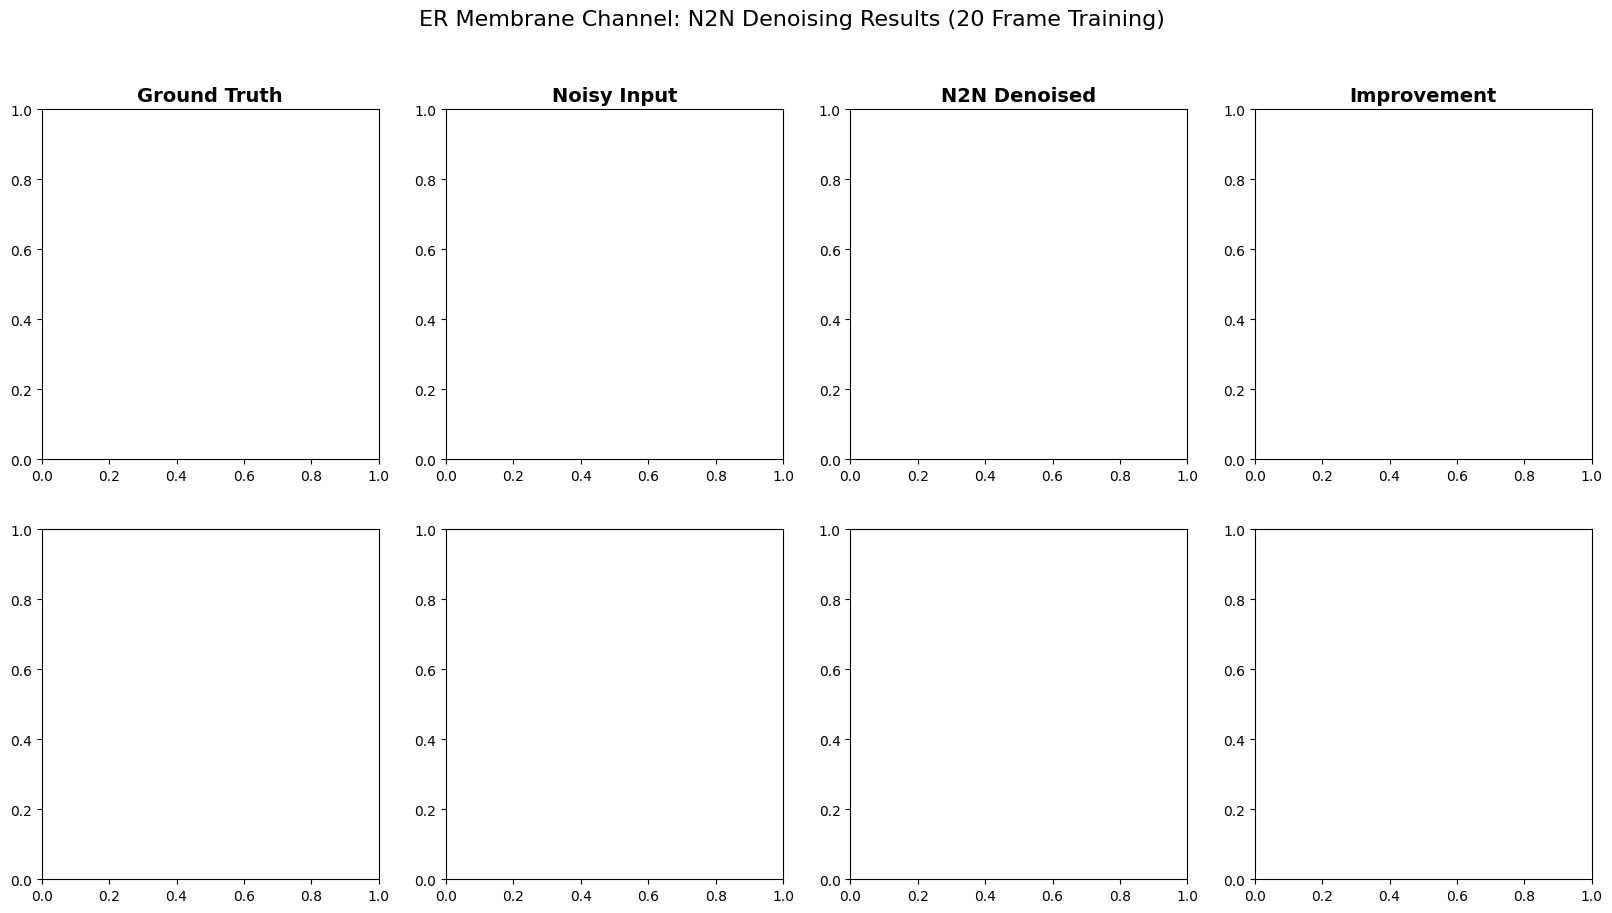

In [4]:
def normalize(img):
    """Normalize image to [0, 1] range"""
    min_val, max_val = img.min(), img.max()
    return (img - min_val) / (max_val - min_val) if max_val > min_val else img - min_val

# Normalize images
gt_normalized = normalize(gt_slice_low_res)

# Calculate metrics and create comparison
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("ER Membrane Channel: N2N Denoising Results (20 Frame Training)", fontsize=16)

# Column headers
col_titles = ["Ground Truth", "Noisy Input", "N2N Denoised", "Improvement"]
for col, title in enumerate(col_titles):
    axes[0, col].set_title(title, fontsize=14, fontweight='bold')

In [5]:
for row, noise_config in enumerate(selected_noise_levels):
    noise_name = noise_config["name"]
    
    # Get test data (first frame)
    test_noisy = frame_datasets[noise_name]["noisy_frames"][0]
    test_clean = frame_datasets[noise_name]["clean_frames"][0]
    test_denoised = denoised_n2n_results[noise_name]
    
    # Normalize for visualization and metrics
    noisy_normalized = normalize(test_noisy)
    clean_normalized = normalize(test_clean)
    denoised_normalized = normalize(test_denoised)
    
    # Calculate metrics
    psnr_noisy = scale_invariant_psnr(gt_normalized, noisy_normalized)
    ssim_noisy = micro_structural_similarity(gt_normalized, noisy_normalized)
    psnr_denoised = scale_invariant_psnr(gt_normalized, denoised_normalized)
    ssim_denoised = micro_structural_similarity(gt_normalized, denoised_normalized)
    
    # Create parameter label
    param_label = f"Read: {noise_config['read_noise']}e⁻ | Gain: {noise_config['gain']}× | Exp: {noise_config['exposure_ms']}ms"
    
    # Ground truth
    axes[row, 0].imshow(gt_normalized, cmap='viridis')
    axes[row, 0].set_ylabel(param_label, fontsize=11, fontweight='bold')
    axes[row, 0].axis('off')
    
    # Noisy input
    axes[row, 1].imshow(noisy_normalized, cmap='viridis')
    axes[row, 1].set_title(f"PSNR: {psnr_noisy:.2f}\nSSIM: {ssim_noisy:.3f}")
    axes[row, 1].axis('off')
    
    # N2N denoised result
    axes[row, 2].imshow(denoised_normalized, cmap='viridis')
    axes[row, 2].set_title(f"PSNR: {psnr_denoised:.2f}\nSSIM: {ssim_denoised:.3f}")
    axes[row, 2].axis('off')
    
    # Improvement visualization
    improvement = np.abs(noisy_normalized - denoised_normalized)
    axes[row, 3].imshow(improvement, cmap='hot')
    psnr_improvement = psnr_denoised - psnr_noisy
    ssim_improvement = ssim_denoised - ssim_noisy
    axes[row, 3].set_title(f"ΔPSNR: +{psnr_improvement:.2f}\nΔSSIM: +{ssim_improvement:.3f}")
    axes[row, 3].axis('off')
    
    print(f"\n{noise_name.upper()} N2N RESULTS:")
    print(f"  Noisy Input  - PSNR: {psnr_noisy:6.2f}, SSIM: {ssim_noisy:.3f}")
    print(f"  N2N Denoised - PSNR: {psnr_denoised:6.2f}, SSIM: {ssim_denoised:.3f}")
    print(f"  Improvement  - ΔPSNR: {psnr_improvement:+6.2f}, ΔSSIM: {ssim_improvement:+.3f}")

plt.tight_layout()
plt.savefig(output_dir / "er_n2n_comparison_20_frames.png", dpi=300, bbox_inches='tight')
plt.show()


EXTREME1 N2N RESULTS:
  Noisy Input  - PSNR:  18.38, SSIM: 0.313
  N2N Denoised - PSNR:  22.25, SSIM: 0.680
  Improvement  - ΔPSNR:  +3.88, ΔSSIM: +0.366

EXTREME2 N2N RESULTS:
  Noisy Input  - PSNR:  14.58, SSIM: 0.166
  N2N Denoised - PSNR:  20.39, SSIM: 0.497
  Improvement  - ΔPSNR:  +5.80, ΔSSIM: +0.331


<Figure size 640x480 with 0 Axes>

Creating frame variance analysis...


Text(0.5, 0.98, 'N2N Training Data Analysis: Frame Diversity')

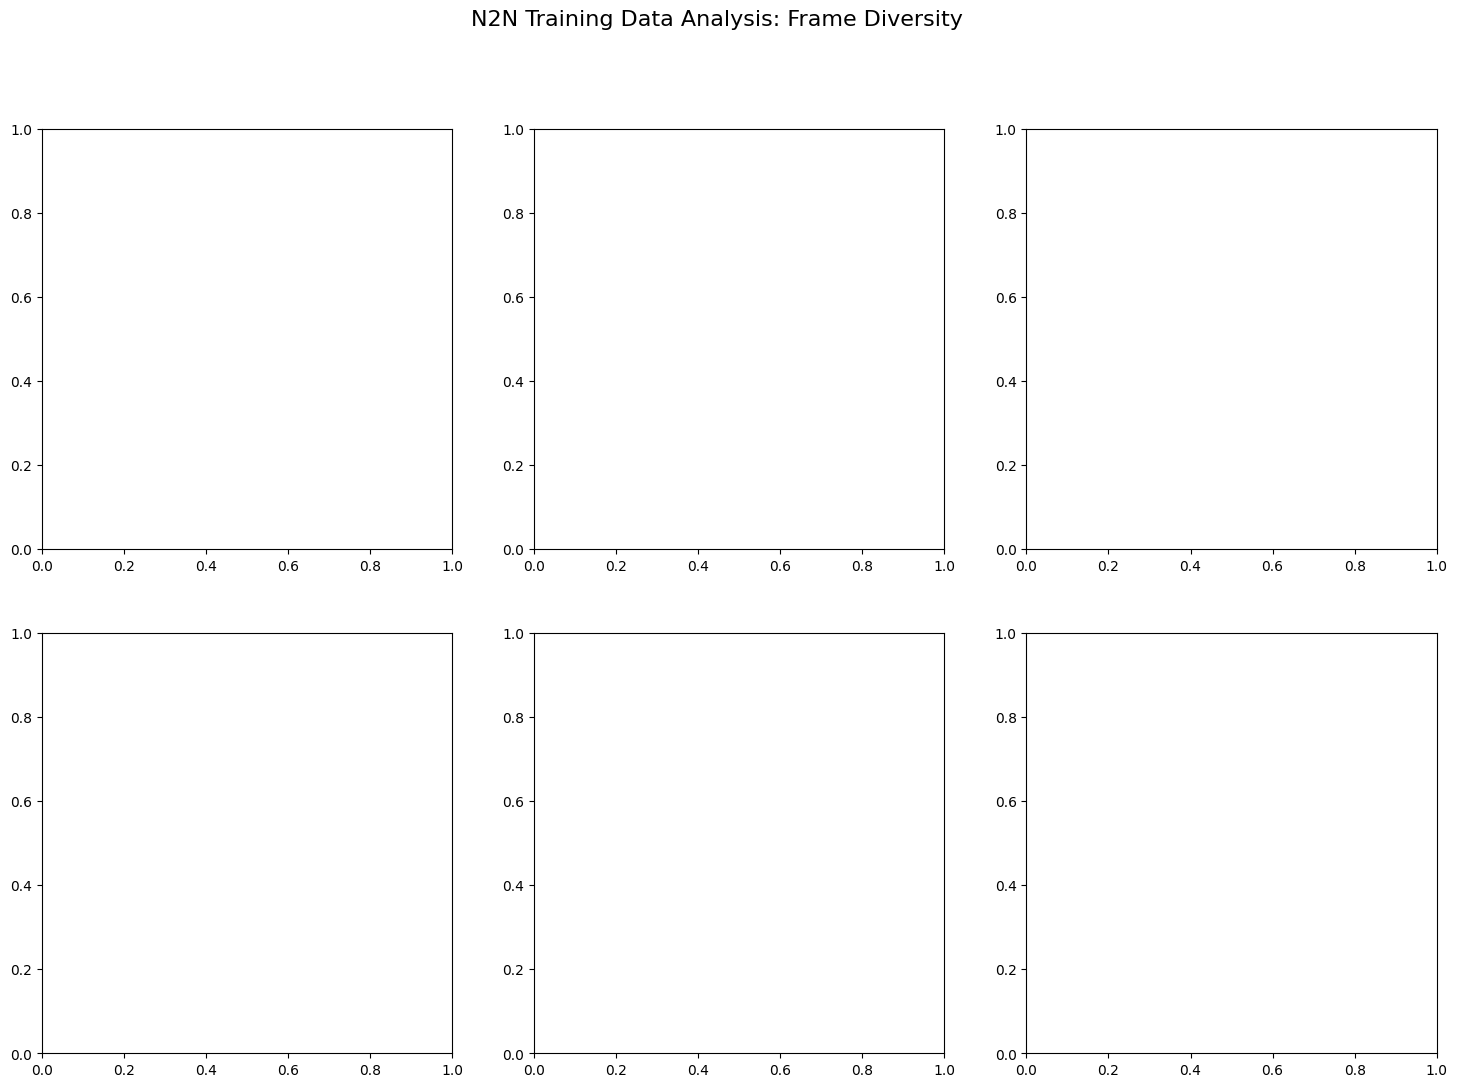

In [6]:
# Create frame variance analysis to show training data diversity
print("Creating frame variance analysis...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("N2N Training Data Analysis: Frame Diversity", fontsize=16)

In [7]:
for row, noise_config in enumerate(selected_noise_levels):
    noise_name = noise_config["name"]
    
    # Calculate statistics across 20 frames
    noisy_stack = np.stack(frame_datasets[noise_name]["noisy_frames"])
    clean_stack = np.stack(frame_datasets[noise_name]["clean_frames"])
    
    # Mean images
    mean_noisy = np.mean(noisy_stack, axis=0)
    mean_clean = np.mean(clean_stack, axis=0)
    std_noisy = np.std(noisy_stack, axis=0)
    
    # Display mean noisy
    axes[row, 0].imshow(normalize(mean_noisy), cmap='viridis')
    axes[row, 0].set_title(f"{noise_name}: Mean Noisy (20 frames)" if row == 0 else f"{noise_name}: Mean Noisy")
    axes[row, 0].axis('off')
    
    # Display mean clean
    axes[row, 1].imshow(normalize(mean_clean), cmap='viridis')
    axes[row, 1].set_title("Mean Clean" if row == 0 else "")
    axes[row, 1].axis('off')
    
    # Display noise variance
    axes[row, 2].imshow(std_noisy, cmap='hot')
    axes[row, 2].set_title("Noise Std Dev" if row == 0 else "")
    axes[row, 2].axis('off')

plt.tight_layout()
plt.savefig(output_dir / "er_n2n_frame_diversity_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\nN2N analysis complete!")
print(f"Generated 20 frames each for {len(selected_noise_levels)} noise conditions")
print(f"Trained {len(selected_noise_levels)} N2N models using supervised learning")
print(f"Results saved to: {output_dir}")
print("\nKey differences from N2V:")
print("- N2N requires paired clean-noisy data (20 frame pairs each)")
print("- N2N uses supervised learning instead of self-supervised")
print("- N2N should theoretically achieve better performance with sufficient training data")

<Figure size 640x480 with 0 Axes>


N2N analysis complete!
Generated 20 frames each for 2 noise conditions
Trained 2 N2N models using supervised learning
Results saved to: er_channel_n2n_multiple_frames

Key differences from N2V:
- N2N requires paired clean-noisy data (20 frame pairs each)
- N2N uses supervised learning instead of self-supervised
- N2N should theoretically achieve better performance with sufficient training data


Analyzing signal distribution across Z-slices...
Z-slice 0: Signal sum = 276177856.00
Z-slice 1: Signal sum = 321683520.00
Z-slice 2: Signal sum = 367792736.00
Z-slice 3: Signal sum = 412254688.00
Z-slice 4: Signal sum = 452901728.00
Z-slice 5: Signal sum = 487848096.00
Z-slice 6: Signal sum = 515613280.00
Z-slice 7: Signal sum = 535226144.00
Z-slice 8: Signal sum = 546381568.00
Z-slice 9: Signal sum = 549539648.00
Z-slice 10: Signal sum = 545852224.00
Z-slice 11: Signal sum = 536894144.00
Z-slice 12: Signal sum = 524360096.00
Z-slice 13: Signal sum = 509751264.00
Z-slice 14: Signal sum = 494173056.00
Z-slice 15: Signal sum = 478273728.00
Z-slice 16: Signal sum = 462365152.00
Z-slice 17: Signal sum = 446520224.00
Z-slice 18: Signal sum = 430668256.00
Z-slice 19: Signal sum = 414695968.00
Z-slice 20: Signal sum = 398493856.00
Z-slice 21: Signal sum = 382005856.00
Z-slice 22: Signal sum = 365259776.00
Z-slice 23: Signal sum = 348361568.00
Z-slice 24: Signal sum = 331451360.00
Z-slice 25:

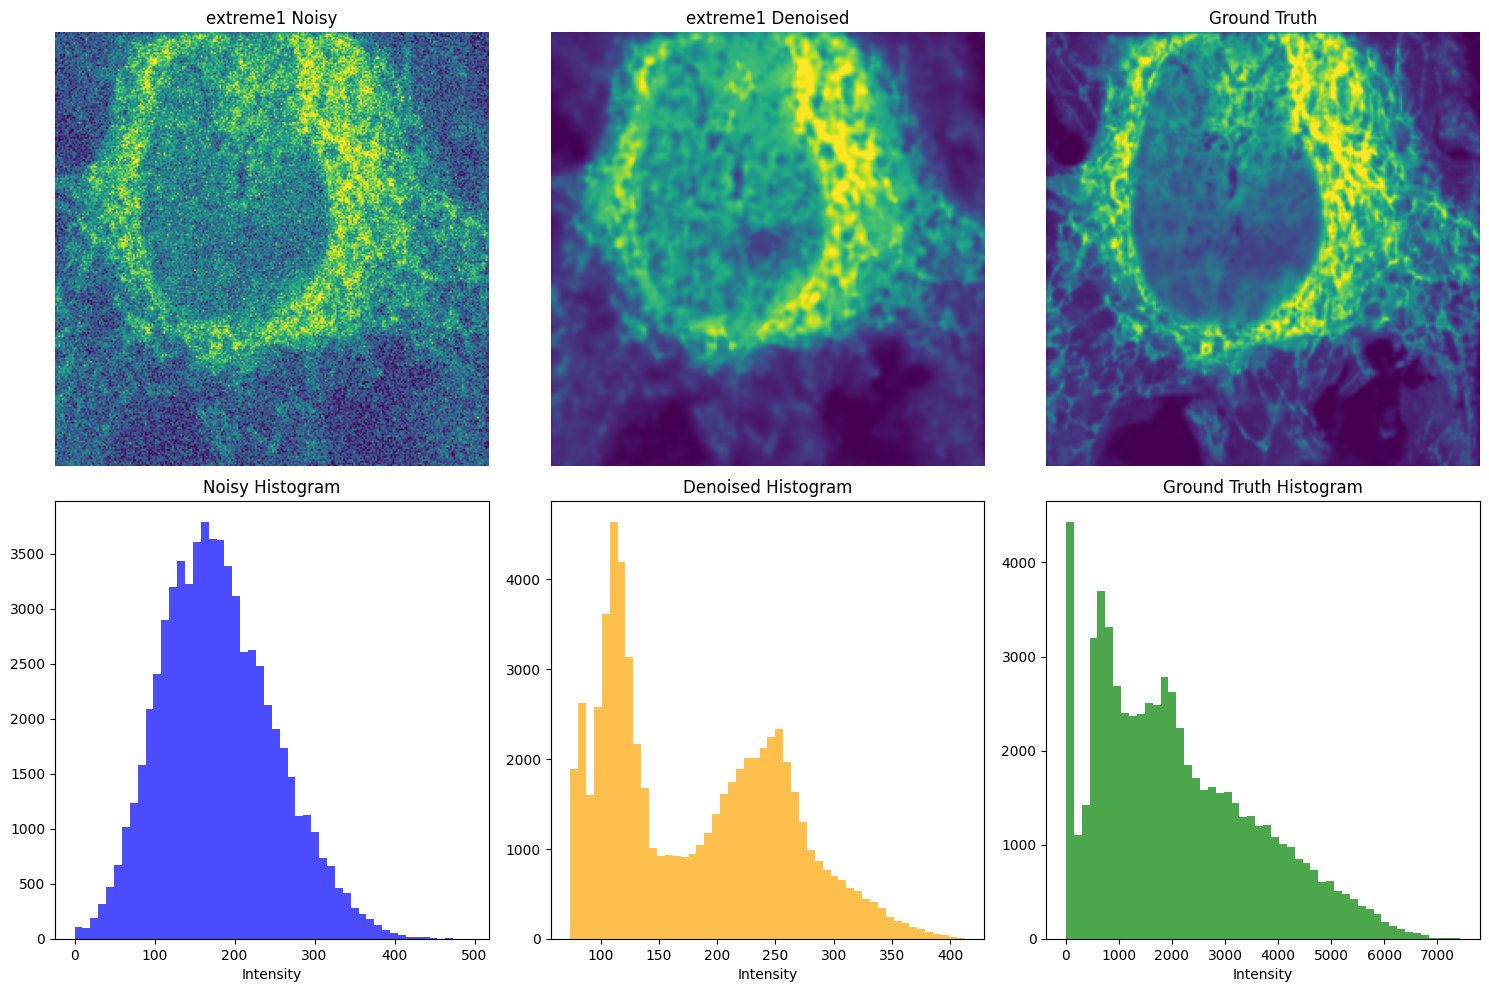


extreme2 Diagnostics:
  Noisy: shape=(256, 256), range=[0.000, 450.000]
  Denoised: shape=(256, 256), range=[31.643, 310.203]
  Ground truth: shape=(256, 256), range=[0.113, 7436.339]


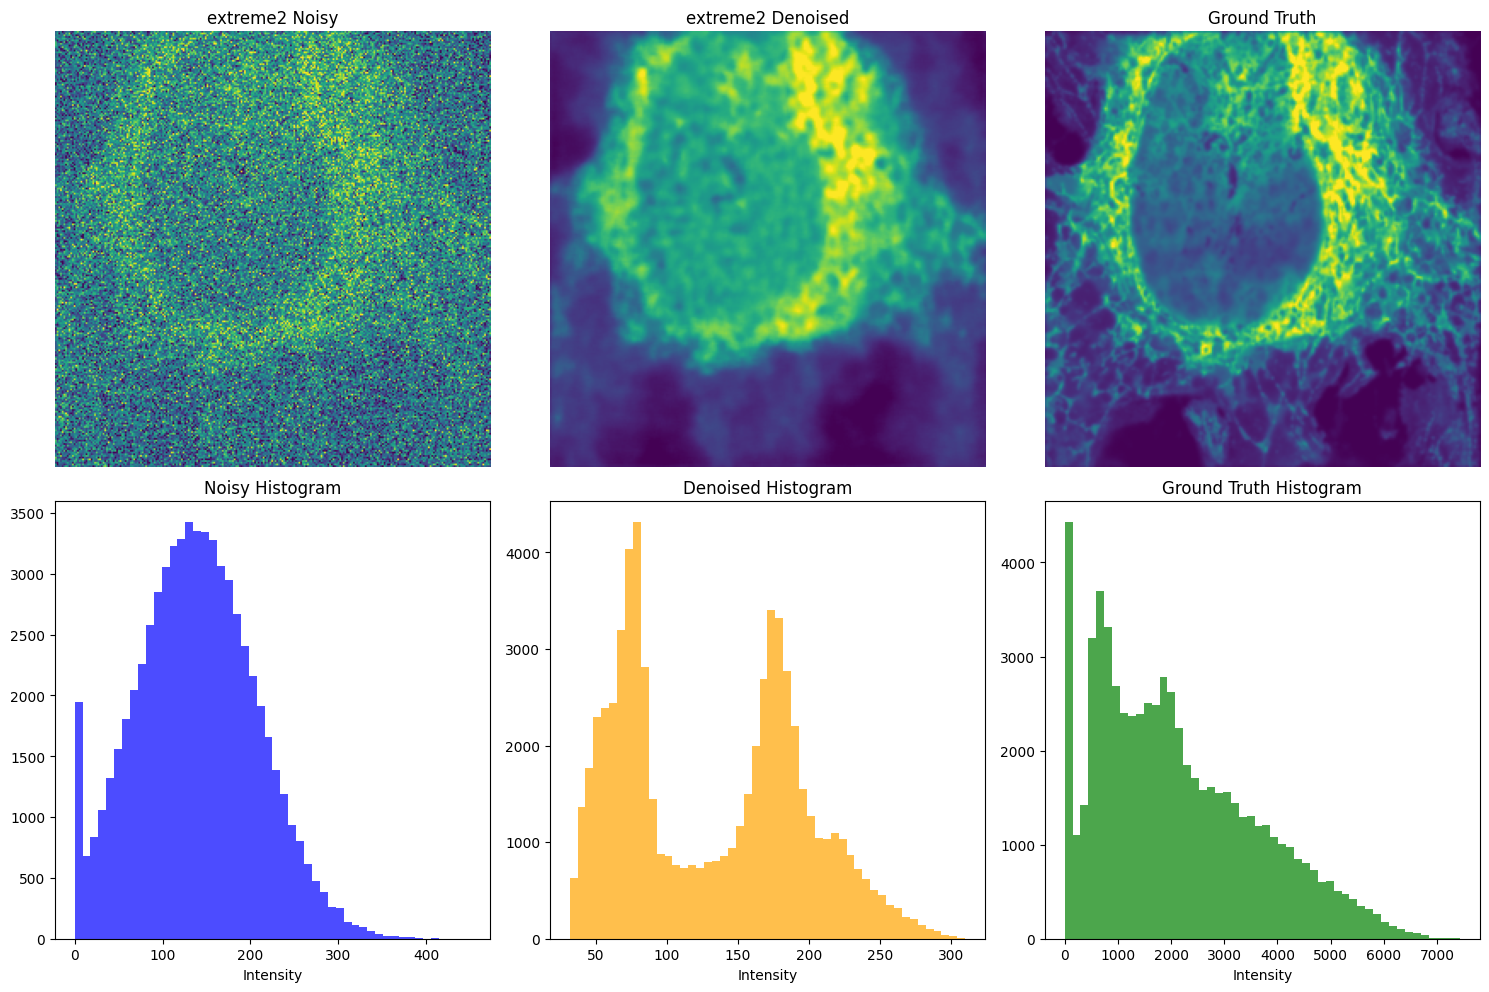

In [9]:
# Fix visualization issues by improving Z-slice selection and data handling

# 1. Select Z-slice with maximum ER signal across all channels
print("Analyzing signal distribution across Z-slices...")
for z in range(optical_image_gt.shape[1]):  # Check multiple slices
    slice_signal = optical_image_gt[channel_index, z].data.sum()
    print(f"Z-slice {z}: Signal sum = {slice_signal:.2f}")

# Select slice with peak signal
signal_per_z = [optical_image_gt[channel_index, z].data.sum() for z in range(optical_image_gt.shape[1])]
z_slice_index = np.argmax(signal_per_z)
print(f"Selected Z-slice {z_slice_index} with signal sum: {signal_per_z[z_slice_index]:.2f}")

# 2. Fix normalization function with proper bounds checking
def normalize_robust(img):
    """Robust normalization with outlier handling"""
    img_flat = img.flatten()
    # Use percentile-based normalization to handle outliers
    p1, p99 = np.percentile(img_flat, [1, 99])
    img_clipped = np.clip(img, p1, p99)
    return (img_clipped - p1) / (p99 - p1) if p99 > p1 else np.zeros_like(img)

# 3. Enhanced visualization with diagnostic information
def create_diagnostic_visualization(noise_name, noisy_slice, denoised_slice, gt_slice):
    """Create visualization with data diagnostics"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Normalize with diagnostics
    noisy_norm = normalize_robust(noisy_slice)
    denoised_norm = normalize_robust(denoised_slice) 
    gt_norm = normalize_robust(gt_slice)
    
    # Print data diagnostics
    print(f"\n{noise_name} Diagnostics:")
    print(f"  Noisy: shape={noisy_slice.shape}, range=[{noisy_slice.min():.3f}, {noisy_slice.max():.3f}]")
    print(f"  Denoised: shape={denoised_slice.shape}, range=[{denoised_slice.min():.3f}, {denoised_slice.max():.3f}]")
    print(f"  Ground truth: shape={gt_slice.shape}, range=[{gt_slice.min():.3f}, {gt_slice.max():.3f}]")
    
    # Top row: Full images
    axes[0, 0].imshow(noisy_norm, cmap='viridis')
    axes[0, 0].set_title(f'{noise_name} Noisy')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(denoised_norm, cmap='viridis')
    axes[0, 1].set_title(f'{noise_name} Denoised')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(gt_norm, cmap='viridis')
    axes[0, 2].set_title(f'Ground Truth')
    axes[0, 2].axis('off')
    
    # Bottom row: Intensity histograms
    axes[1, 0].hist(noisy_slice.flatten(), bins=50, alpha=0.7, color='blue')
    axes[1, 0].set_title('Noisy Histogram')
    axes[1, 0].set_xlabel('Intensity')
    
    axes[1, 1].hist(denoised_slice.flatten(), bins=50, alpha=0.7, color='orange')
    axes[1, 1].set_title('Denoised Histogram')
    axes[1, 1].set_xlabel('Intensity')
    
    axes[1, 2].hist(gt_slice.flatten(), bins=50, alpha=0.7, color='green')
    axes[1, 2].set_title('Ground Truth Histogram')
    axes[1, 2].set_xlabel('Intensity')
    
    plt.tight_layout()
    return fig

# 4. Apply fixes to main visualization loop
for row, noise_config in enumerate(selected_noise_levels):
    noise_name = noise_config["name"]
    
    # Ensure proper data extraction
    test_noisy = np.array(frame_datasets[noise_name]["noisy_frames"][0])
    test_denoised = np.array(denoised_n2n_results[noise_name])
    test_gt = np.array(gt_slice_low_res)
    
    # Create diagnostic visualization
    fig = create_diagnostic_visualization(noise_name, test_noisy, test_denoised, test_gt)
    fig.savefig(output_dir / f"diagnostic_{noise_name}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
# Appropriate metric calculation for N2N evaluation
def calculate_n2n_metrics(gt_reference, noisy_input, denoised_output):
    """Calculate metrics using shared ground truth reference"""
    
    # Normalize all images to [0,1] for consistent comparison
    gt_norm = normalize_robust(gt_reference)
    noisy_norm = normalize_robust(noisy_input) 
    denoised_norm = normalize_robust(denoised_output)
    
    # Calculate metrics against ground truth
    psnr_noisy = scale_invariant_psnr(gt_norm, noisy_norm)
    psnr_denoised = scale_invariant_psnr(gt_norm, denoised_norm)
    ssim_noisy = micro_structural_similarity(gt_norm, noisy_norm)
    ssim_denoised = micro_structural_similarity(gt_norm, denoised_norm)
    
    return {
        'psnr_noisy': psnr_noisy,
        'psnr_denoised': psnr_denoised,
        'ssim_noisy': ssim_noisy, 
        'ssim_denoised': ssim_denoised,
        'psnr_improvement': psnr_denoised - psnr_noisy,
        'ssim_improvement': ssim_denoised - ssim_noisy
    }

In [11]:
# Reserve frames for proper train/test split
train_frames = frame_datasets[noise_name]["noisy_frames"][:-5]  # Use 15 for training
test_frames = frame_datasets[noise_name]["noisy_frames"][-5:]   # Reserve 5 for testing

# Calculate metrics across multiple test frames
test_metrics = []
for test_frame in test_frames:
    metrics = calculate_n2n_metrics(gt_slice_low_res, test_frame, denoised_output)
    test_metrics.append(metrics)

# Report mean and standard deviation
mean_psnr_improvement = np.mean([m['psnr_improvement'] for m in test_metrics])
std_psnr_improvement = np.std([m['psnr_improvement'] for m in test_metrics])

NameError: name 'denoised_output' is not defined